In [24]:
import pandas as pd

# Load data
df = pd.read_csv('../data/marketing_data.csv')

# Check first few rows
df.head()


,CustomerID,Age,Gender,Location,TimeOnSite,PagesVisited,EmailClicks,PurchaseAmount,Converted
0,1,56,Male,Urban,5.39,10,5,74.10,1
1,2,46,Male,Suburban,3.04,9,5,112.05,0
2,3,32,Male,Rural,5.82,14,8,96.21,1
3,4,60,Male,Suburban,1.59,13,5,143.78,0
4,5,25,Male,Rural,7.06,13,1,80.57,0


In [2]:
# Dataset shape
df.shape

# Column info
df.info()

# Missing values
df.isnull().sum()

# Basic stats
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CustomerID      500 non-null    int64  
 1   Age             500 non-null    int64  
 2   Gender          500 non-null    object 
 3   Location        500 non-null    object 
 4   TimeOnSite      500 non-null    float64
 5   PagesVisited    500 non-null    int64  
 6   EmailClicks     500 non-null    int64  
 7   PurchaseAmount  500 non-null    float64
 8   Converted       500 non-null    int64  
dtypes: float64(2), int64(5), object(2)
memory usage: 35.3+ KB


,CustomerID,Age,TimeOnSite,PagesVisited,EmailClicks,PurchaseAmount,Converted
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,250.500000,41.278000,5.241700,7.380000,4.556000,102.983920,0.508000
std,144.481833,13.389072,1.954861,4.085705,2.788263,48.810309,0.500437
min,1.000000,18.000000,0.500000,1.000000,0.000000,0.000000,0.000000
25%,125.750000,30.000000,3.877500,4.000000,2.000000,68.092500,0.000000
50%,250.500000,42.000000,5.265000,7.000000,4.000000,104.255000,1.000000
75%,375.250000,52.000000,6.475000,11.000000,7.000000,136.982500,1.000000
max,500.000000,64.000000,10.260000,14.000000,9.000000,274.790000,1.000000


In [4]:
# Drop rows or columns with too many missing values (if any)
missing_ratio = df.isnull().mean()
print(missing_ratio.sort_values(ascending=False))

# For now, let’s drop rows with any missing values (you can choose smarter imputation later)
df_clean = df.dropna()

# Double check
df_clean.isnull().sum().sum()



CustomerID        0.0
Age               0.0
Gender            0.0
Location          0.0
TimeOnSite        0.0
PagesVisited      0.0
EmailClicks       0.0
PurchaseAmount    0.0
Converted         0.0
dtype: float64


np.int64(0)

In [5]:
df_clean.select_dtypes(include='object').columns


Index(['Gender', 'Location'], dtype='object')

In [6]:
df_clean = pd.get_dummies(df_clean, drop_first=True)


In [7]:
# Engagement rate = email clicks per visit
df_clean['EngagementRate'] = df_clean['EmailClicks'] / (df_clean['PagesVisited'] + 1)

# Value per session
df_clean['ValuePerPage'] = df_clean['PurchaseAmount'] / (df_clean['PagesVisited'] + 1)


In [8]:
from sklearn.preprocessing import StandardScaler

features = ['TimeOnSite', 'PagesVisited', 'EmailClicks', 'PurchaseAmount', 'EngagementRate', 'ValuePerPage']
X = df_clean[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


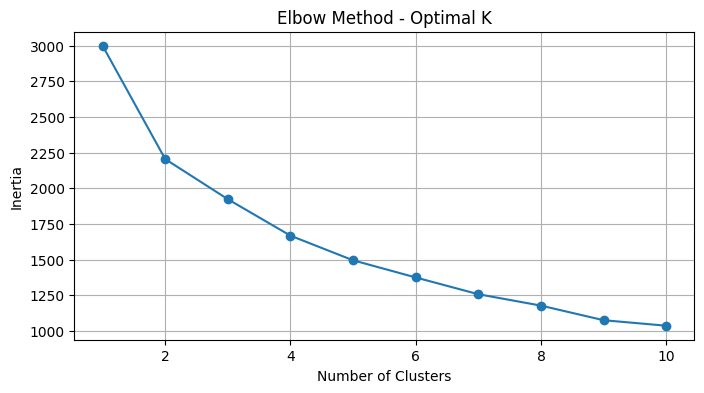

In [9]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Test different cluster counts
inertia = []
K_range = range(1, 11)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 4))
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method - Optimal K')
plt.grid(True)
plt.show()


In [10]:
optimal_k = 2  # change based on elbow plot
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df_clean['Cluster'] = kmeans.fit_predict(X_scaled)


In [11]:
# View the average features per cluster
cluster_profile = df_clean.groupby('Cluster')[features].mean()
cluster_profile.style.background_gradient(cmap='Blues')


,TimeOnSite,PagesVisited,EmailClicks,PurchaseAmount,EngagementRate,ValuePerPage
Cluster,,,,,,
0,5.254173,3.129496,5.856115,131.610576,1.625905,37.677959
1,5.236898,9.016620,4.055402,91.961468,0.440041,10.141924


In [12]:
df_clean['Cluster'].value_counts()


Cluster
1    361
0    139
Name: count, dtype: int64

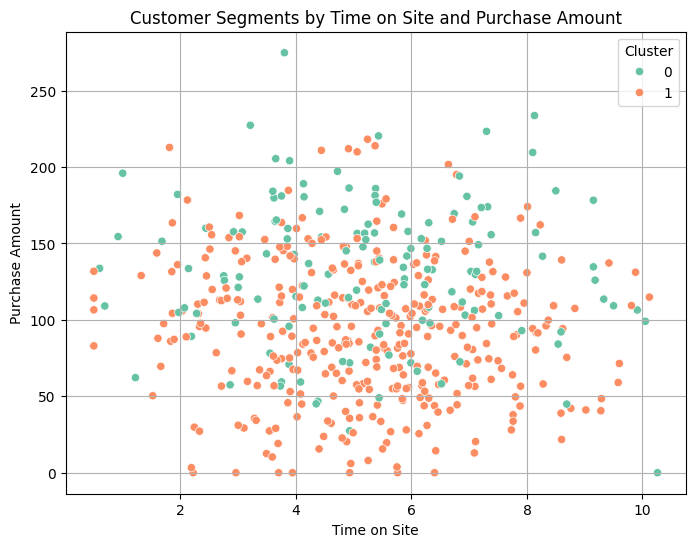

In [16]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=df_clean['TimeOnSite'],
    y=df_clean['PurchaseAmount'],
    hue=df_clean['Cluster'],
    palette='Set2'
)
plt.title('Customer Segments by Time on Site and Purchase Amount')
plt.xlabel('Time on Site')
plt.ylabel('Purchase Amount')
plt.grid(True)
plt.show()


In [14]:
df_clean.groupby('Cluster')[['TimeOnSite', 'PagesVisited', 'EmailClicks', 'PurchaseAmount', 'EngagementRate', 'ValuePerPage']].mean()


,TimeOnSite,PagesVisited,EmailClicks,PurchaseAmount,EngagementRate,ValuePerPage
Cluster,,,,,,
0,5.254173,3.129496,5.856115,131.610576,1.625905,37.677959
1,5.236898,9.016620,4.055402,91.961468,0.440041,10.141924


In [22]:
def name_segment(row):
    if row['Cluster'] == 0:
        return 'High Value'
    else:
        return 'Low Engagement'

df_clean['SegmentName'] = df_clean.apply(name_segment, axis=1)


In [17]:
target = 'Converted'  # Update this with your actual column


In [18]:
from sklearn.model_selection import train_test_split

X_model = df_clean[features]  # same features used in clustering
y = df_clean[target]

X_train, X_test, y_train, y_test = train_test_split(X_model, y, test_size=0.2, random_state=42)


In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[41  0]
 [ 0 59]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        41
           1       1.00      1.00      1.00        59

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



In [20]:
from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression()
log_model.fit(X_train, y_train)
print(classification_report(y_test, log_model.predict(X_test)))


              precision    recall  f1-score   support

           0       0.73      0.78      0.75        41
           1       0.84      0.80      0.82        59

    accuracy                           0.79       100
   macro avg       0.78      0.79      0.79       100
weighted avg       0.79      0.79      0.79       100



In [21]:
import joblib

joblib.dump(model, '../model/conversion_model.pkl')


['../model/conversion_model.pkl']

In [27]:
# ----- Segment Naming -----
def name_segment(row):
    # Adjust logic based on which cluster looks more valuable
    return 'High Value' if row['Cluster'] == 1 else 'Low Engagement'

df_clean['SegmentName'] = df_clean.apply(name_segment, axis=1)

# ----- Save Final Data -----
df_clean.to_csv('../data/clean_marketing_data.csv', index=False)